# Land Options
This looks at how the roughness length, albedo and heat capacity affect the properties of land.

For all simulations, a bucket model is used over land with a vegetation factor, $C_V=0.1$. Then it looks at the effect of increasing roughness length, increasing albedo and reducing heat capacity over land in addition to the reduced evaporation over land.

For any given simulation, only one of roughness length, albedo or heat capacity is adjusted.

In [2]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.utils.constants import kappa, L_v, c_p, g, R_v, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
from isca_tools.papers.byrne_2021 import get_delta_temp_quant_theory, get_px, get_quant_ind, get_gamma
import warnings

2023-06-20 16:05:23,494 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset - one at surface and one in free troposphere
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = ['tau_sweep/land/meridional_band/bucket_evap/evap=0_1/',
           'tau_sweep/land/meridional_band/options/roughness/prefactor=10/',
           'tau_sweep/land/meridional_band/options/albedo/prefactor=1_3/',
           'tau_sweep/land/meridional_band/options/h_capacity/prefactor=0_1/']
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
option_names = ['None', 'Roughness', 'Albedo', 'Heat Capacity']
n_options = len(exp_dir)
n_exp = len(exp_names)
ds = [[] for i in range(n_options)]
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_exp*n_options, position=0, leave=True) as pbar:
    for j in range(n_options):
        # only keep variables required to compute relative humidity
        var_keep = ['temp', 'sphum', 'height', 'bucket_depth']
        for i in range(n_exp):
            ds_use = isca_tools.load_dataset(exp_dir[j] + exp_names[i])[var_keep]
            ds[j] += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
            namelist = isca_tools.load_namelist(exp_dir[j] + exp_names[i])  # Need this for albedo_value
            albedo += [namelist['mixed_layer_nml']['albedo_value']]
            tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
            tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
            if j == 1:
                max_bucket_depth_land = namelist['idealized_moist_phys_nml']['max_bucket_depth_land']
            pbar.update(1)
p_surface = float(ds[0][0].pfull) * 100  # pressure where surface temperature is computed - same for all ds

100%|██████████| 3/3 [00:00<00:00, 17.41it/s]


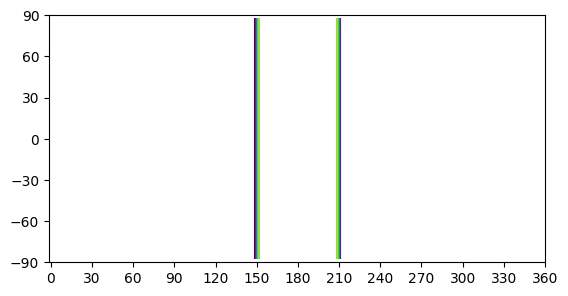

In [15]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir[0], exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get two datasets, `ds_all`, one for ocean and one for land, for a given latitude bin.

In [16]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [17]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
# season = 'summer'
season = 'all'

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65

ds_all = {'land':[[] for i in range(n_options)], 'ocean': [[] for i in range(n_options)]}
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
with tqdm(total=n_exp*n_options*2, position=0, leave=True) as pbar:
    for j in range(n_options):
        for i in range(n_exp):
            ds_use = ds[j][i].sel(time=slice(use_time_start, np.inf))
            ds_use = ds_use.where((np.abs(ds_use.lat) < lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
            if season == 'summer':
                # Only consider summer as has expected circulation
                ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
                ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
                # Combine hemispheres and average over longitude, time and latitude.
                # Note that April, May, June, October, November and December will not be included in this dataset
                ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            ds_use = ds_use.load()
            for surf in ['land', 'ocean']:
                ds_all[surf][j] += [ds_use.isel(lon_time=np.where(np.isin(ds_use.lon, np.unique(lon[surf])))[0])]
                pbar.update(1)

100%|██████████| 16/16 [01:31<00:00,  5.69s/it]


## RH change vs Temperature Percentile
Recreating Extended Data Figure 2, Figure 3 and Figure 2b of Byrne 2021.

In [22]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
surfaces = ['ocean', 'land']
n_surf = len(surfaces)
quant_plot = np.arange(100)     # first value must be 0 so temp_quant[0] is the mean value
n_quant = len(quant_plot)
n_lat = len(ds_all['ocean'][0][0].lat)
lat_weights = np.cos(np.deg2rad(ds_all['ocean'][0][0].lat))     # latitude area weighting is just the cosine

# surface values corresponding to the average obove a given percentile in temperature
temp_quant = {'ocean': np.zeros((n_options, n_exp, n_lat, n_quant)), 'land': np.zeros((n_options, n_exp, n_lat, n_quant))}
temp_quant2 = {'ocean': np.zeros((n_options, n_exp, n_lat, n_quant)), 'land': np.zeros((n_options, n_exp, n_lat, n_quant))}
sphum_quant = {'ocean': np.zeros((n_options, n_exp, n_lat, n_quant)), 'land': np.zeros((n_options, n_exp, n_lat, n_quant))}
sphum_quant2 = {'ocean': np.zeros((n_options, n_exp, n_lat, n_quant)), 'land': np.zeros((n_options, n_exp, n_lat, n_quant))}
rh_quant = {'ocean': np.zeros((n_options, n_exp, n_lat, n_quant)), 'land': np.zeros((n_options, n_exp, n_lat, n_quant))}
mse_quant2 = {'ocean': np.zeros((n_options, n_exp, n_lat, n_quant)), 'land': np.zeros((n_options, n_exp, n_lat, n_quant))}
bucket_quant =  np.zeros((n_options, n_exp, n_lat, n_quant))


with tqdm(total=n_options*n_exp*n_quant*n_surf*n_lat, position=0, leave=True) as pbar:
    for j in range(n_options):
        for i in range(n_exp):
            for k in range(n_lat):
                for surf in surfaces:
                    mse = moist_static_energy(ds_all[surf][j][i].temp[k], ds_all[surf][j][i].sphum[k], ds_all[surf][j][i].height[k])
                    mse_quant2[surf][j, i, k] = mse.quantile(quant_plot/100, dim='lon_time', keep_attrs=True)
                    temp_quant2[surf][j, i, k] = ds_all[surf][j][i].temp[k].quantile(quant_plot/100, dim='lon_time', keep_attrs=True)
                    sphum_quant2[surf][j, i, k] = ds_all[surf][j][i].sphum[k].quantile(quant_plot/100, dim='lon_time', keep_attrs=True)
                    for q, quant in enumerate(quant_plot):
                        use_ind = get_quant_ind(ds_all[surf][j][i].temp[k], quant)
                        temp_quant[surf][j, i, k, q] = ds_all[surf][j][i].temp[k][use_ind].mean()
                        sphum_quant[surf][j, i, k, q] = ds_all[surf][j][i].sphum[k][use_ind].mean()
                        # compute the pseudo relative humidity averaged over hot days
                        rh_quant[surf][j, i, k, q] = sphum_quant[surf][j, i, k, q] / sphum_sat(temp_quant[surf][j, i, k, q], p_surface)
                        if surf == 'land':
                            # compute bucket depth averaged over hot days if using bucket method
                            bucket_quant[j, i, k, q] = ds_all[surf][j][i].bucket_depth[k][use_ind].mean()
                        pbar.update(1)

100%|██████████| 22400/22400 [02:19<00:00, 160.36it/s]


In [23]:
# get latitude weighted quantities
rh_quant_weight = {surf: np.average(rh_quant[surf], axis=2, weights=lat_weights)*100
                          for surf in surfaces}
bucket_quant_weight = np.average(bucket_quant, axis=2, weights=lat_weights)
rh_change_quant_weight = {surf: np.average(rh_quant[surf][:, 1]-rh_quant[surf][:, 0], axis=1, weights=lat_weights)*100
                          for surf in surfaces}
delta_land_ocean_ratio = [np.average((var['land'][:, 1]-var['land'][:, 0])/
                                 (var['ocean'][:, 1]-var['ocean'][:, 0]), axis=1, weights=lat_weights) for var in
                          [temp_quant2, sphum_quant2, mse_quant2]]
# lambda_param_weight = np.average((mse_quant2['land'][:, 1]-mse_quant2['land'][:, 0])/
#                                  (mse_quant2['ocean'][:, 1]-mse_quant2['ocean'][:, 0]), axis=1, weights=lat_weights)
scale_factor = {surf: np.average((temp_quant[surf][:, 1]-temp_quant[surf][:, 0])/
                                 (temp_quant[surf][:, 1, :, :1]-temp_quant[surf][:, 0, :, :1]),
                                 axis=1, weights=lat_weights) for surf in surfaces}

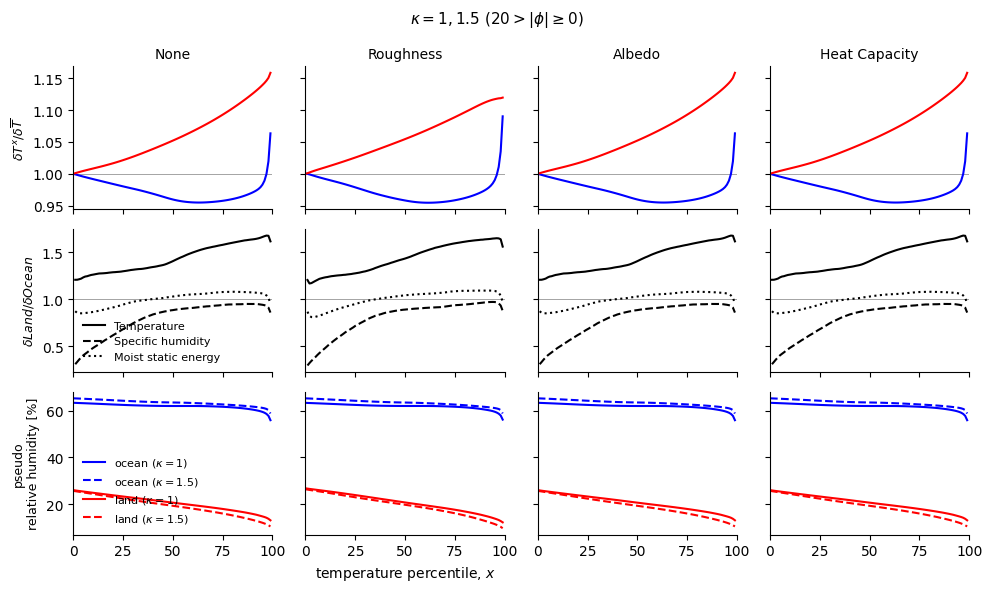

In [24]:
save_land_def_fig = False
plt_color = {'land': 'red', 'ocean': 'blue'}
linestyles = ['-','--', ':']
# labels = [f'Constant, $C_L = {evap_param[0]}$', f'Bucket, $C_V={evap_param[1]}$', f'Bucket, $C_V={evap_param[2]}$']
lambda_labels = ['Temperature', 'Specific humidity', 'Moist static energy']
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(3,n_options, figsize=(10, 6), sharex=True, sharey='row')
for j in range(n_options):
    for i in range(3):
        ax[i,j].spines[['right', 'top']].set_visible(False)
    for k in range(len(delta_land_ocean_ratio)):
        ax[1, j].plot(quant_plot[1:], delta_land_ocean_ratio[k][j][1:], color='k', label=lambda_labels[k], linestyle=linestyles[k])
    ax[1, j].hlines(1, 0, 100, color='k', lw=0.5, alpha=0.5)
    ax[0, j].hlines(1, 0, 100, color='k', lw=0.5, alpha=0.5)
    ax[0, j].set_title(option_names[j], fontsize=10)
    for surf in surfaces:
        for i in range(n_exp):
            ax[2, j].plot(quant_plot, rh_quant_weight[surf][j, i], color=plt_color[surf],
                          linestyle=linestyles[i], label=f'{surf} ($\kappa={tau_lw[i]}$)')
        ax[0, j].plot(quant_plot, scale_factor[surf][j], color=plt_color[surf])
ax[0, 0].set_xlim(0, 100)
ax[2, 0].legend(frameon=False, fontsize=8, loc='lower left')
ax[2, 0].set_ylabel('pseudo\nrelative humidity [%]', fontsize=9)
ax[1, 0].legend(frameon=False, fontsize=8, loc='lower left')
ax[1, 0].set_ylabel('$\delta Land /\delta Ocean$', fontsize=9)
ax[0, 0].set_ylabel('$\delta T^x /\delta \overline{T}$', fontsize=9)
# ax.set_xlabel('temperature percentile, $x$')
fig.suptitle(f'$\kappa={tau_lw[0]}, {tau_lw[1]}$ (${lat_max}>|\phi| \geq {lat_min}$)', fontsize=11)
ax[-1, 1].set_xlabel('temperature percentile, $x$')
plt.tight_layout()
if save_fig or save_land_def_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/land_def_{region.lower()}_{season}",dpi=high_dpi if publish_fig else low_dpi)

The plot below shows that with a lower $C_V$ the bucket doesn't dry out.

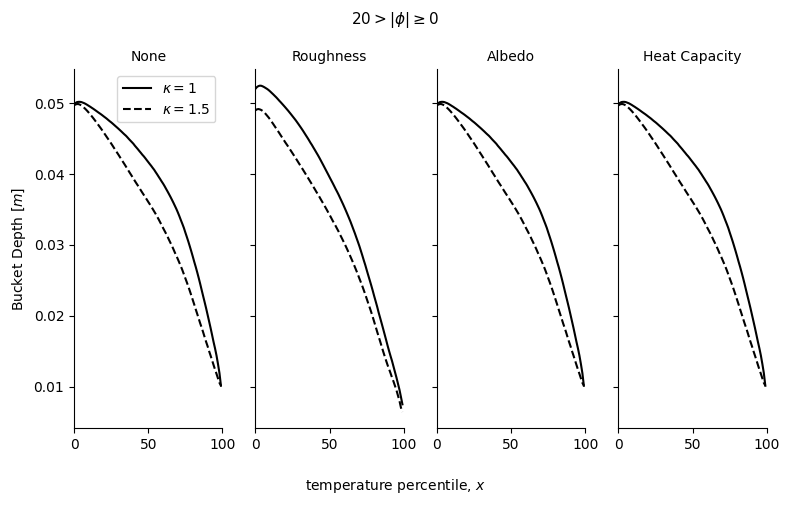

In [25]:
save_bucket_fig = False
fig, ax = plt.subplots(1,n_options, figsize=(8, 5), sharey=True, sharex=True)
for j in range(n_options):
    ax[j].spines[['right', 'top']].set_visible(False)
    ax[j].set_title(option_names[j], fontsize=10)
    for i in range(n_exp):
        ax[j].plot(quant_plot, bucket_quant_weight[j, i], linestyle=linestyles[i], color='k', label=f'$\kappa = {tau_lw[i]}$')
ax[0].legend()
ax[0].set_ylabel('Bucket Depth [$m$]')
fig.supxlabel('temperature percentile, $x$', fontsize=10)
fig.suptitle(f'${lat_max}>|\phi| \geq {lat_min}$', fontsize=11)
ax[0].set_xlim(0,100)
plt.tight_layout()
if save_fig or save_bucket_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/bucket_{region.lower()}_{season}",dpi=high_dpi if publish_fig else low_dpi)

In [37]:
float(ds[0][0].temp[700,21,25])

294.703125

In [4]:
# This shows that the albedo and heat capacity experiments didn't work - they give exactly the same results as if prefactors were set to 1
print('Max Temperature Difference to None experiment')
for i in range(n_options-1):
    print(f"{option_names[i+1]}: {float(np.abs(ds[0][0].temp - ds[i+1][0].temp).max())}")

Max Temperature Difference to None experiment
Roughness: 13.916885375976562
Albedo: 0.0
